# Introduction : objectives

The purpose of this notebook is to process raw data from the flux tower at Col du Lautaret and to prepare it for FFP calculation. It provides a visualization of wind and vegetation characteristics of the site.

# Importation of packages and modules

This notebook was developed with:  
- Python 3.13.2  
- Jupyter Notebook  
- Libraries : pandas, numpy, matplotlib, glob, re, os, astral, pytz, windrose, seaborn
- Modules : data_preparation
- See 'environment.yml' in the repository for more infos. 

In [305]:
import sys
sys.path.append('/home/jovyan//ICOS-M2-internship-alise/scripts/')

In [307]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import data_preparation as datprep
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

import watermark
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [308]:
%watermark --iversions

seaborn   : 0.13.2
matplotlib: 3.10.1
watermark : 2.5.0
windrose  : 1.9.2
xarray    : 2025.3.1
numpy     : 2.2.4
rasterio  : 1.4.3
rioxarray : 0.19.0
sys       : 3.13.2 | packaged by conda-forge | (main, Feb 17 2025, 14:10:22) [GCC 13.3.0]
contextily: 1.6.2
pandas    : 2.2.3



# 1) Data importation

In [309]:
# Import low frequency data (meteorological variables) from 2019 to 2024
lofreq_all = datprep.read_csv_file('/mnt/data-summer-shared/ICOS_Data_AliseROBERT/FR-CLt_*_LoFreq.csv', na_values=[-9999.0])

In [310]:
# Import high frequency data (flux variables) from 2019 to 2024
flux_all = datprep.read_csv_file('/mnt/data-summer-shared/ICOS_Data_AliseROBERT/FR-CLt_*_flux.csv', na_values=[-9999.0])

# 2) Data preparation

## Selection and standardization of the variables

In [311]:
# Standardize the codes of the variable for 2022
lofreq_all[3] = lofreq_all[3].rename(columns={'WD_1_1_1': 'WD_2_1_1'})
flux_all[3] = flux_all[3].rename(columns={'WS_2_1_1': 'WS_1_1_1'})

In [312]:
# Select only interesting columns in flux datasets
useful_columns = ['TIMESTAMP_START','WS_1_1_1', 'MO_LENGTH_1_1_1', 'V_SIGMA_1_1_1', 'USTAR_1_1_1']
flux_all = [flux[useful_columns] for flux in flux_all]

In [313]:
# Format time data 
lofreq_all = datprep.prep_timestamp(lofreq_all)
flux_all = datprep.prep_timestamp(flux_all)

## Add wind direction and snow depth to flux dataframes

In [314]:
# Add the corresponding columns of lofreq dataframes to flux dataframes
columns = ['D_SNOW_1_1_1', 'WD_2_1_1']
flux_all = datprep.add_lofreqcol(flux_all, lofreq_all, columns)

## Concatenate the list of flux dataframes into one single dataframe

In [315]:
flux_data_all = pd.concat(flux_all, ignore_index=True)
print(flux_data_all)

          TIMESTAMP_START  WS_1_1_1  MO_LENGTH_1_1_1  V_SIGMA_1_1_1  \
0     2019-06-01 00:00:00  0.993511          11.2449       0.513305   
1     2019-06-01 00:30:00  0.828337         -12.3615       0.401650   
2     2019-06-01 01:00:00  0.737088         -91.5872       0.510083   
3     2019-06-01 01:30:00  1.490440          18.6913       0.643529   
4     2019-06-01 02:00:00  1.242340          28.5804       0.586084   
...                   ...       ...              ...            ...   
87240 2024-12-12 21:30:00       NaN              NaN            NaN   
87241 2024-12-12 22:00:00       NaN              NaN            NaN   
87242 2024-12-12 22:30:00       NaN              NaN            NaN   
87243 2024-12-12 23:00:00       NaN              NaN            NaN   
87244 2024-12-12 23:30:00       NaN              NaN            NaN   

       USTAR_1_1_1  D_SNOW_1_1_1  WD_2_1_1  
0         0.146562           NaN   252.100  
1         0.080132           NaN   198.200  
2         0.

## Cleaning : remove missing values

In [316]:
# Remove the NaN of the main variables (used later for footprint calculation)
columns = ["WD_2_1_1", "WS_1_1_1", "MO_LENGTH_1_1_1", "V_SIGMA_1_1_1", "USTAR_1_1_1"]
flux_data_all = flux_data_all.dropna(subset=columns)

## Add zm (measurement height) to the dataframe

In [317]:
# Import sensor height
zsensor = pd.read_csv("/mnt/data-summer-shared/ICOS_Data_AliseROBERT/zsensor.csv", sep=';')

# Time formatting
zsensor['date'] = pd.to_datetime(zsensor['date'], format="%Y%m%d")

# Sort sensor heights by dates
zsensor = zsensor.sort_values('date')

In [318]:
print(zsensor)

    h_capteur       date
0        5.01 2015-07-07
1        2.85 2019-10-08
2        3.45 2019-12-03
3        4.10 2020-01-30
4        3.45 2020-03-16
5        2.85 2020-04-22
6        2.80 2020-10-12
7        4.06 2020-12-09
8        2.80 2021-03-31
9        3.97 2021-12-07
10       2.70 2022-05-19
11       4.00 2023-01-06
13       3.00 2023-05-05
12       2.95 2023-07-06
14       3.90 2024-01-11
15       2.95 2024-05-22
16       3.90 2024-12-12


In [319]:
# Associate each date of the flux dataframe with a value of h_capteur
flux_data_all = pd.merge_asof(
    flux_data_all,
    zsensor.rename(columns={'date': 'TIMESTAMP_START'}),
    on='TIMESTAMP_START',
    direction='backward'  # Take the last sensor height known at this date
    )

In [320]:
# For each date, calculate zm : if there is snow, zm is the difference between the sensor height and the snow depth
# If no snow, zm = h_capteur
flux_data_all['zm'] = flux_data_all.apply(
        lambda row: row['h_capteur'] - row['D_SNOW_1_1_1'] 
        if row['D_SNOW_1_1_1'] > 0 else row['h_capteur'], 
        axis=1
    )

## Add an arbitrary value for the boundary layer height h

In [321]:
flux_data_all['H_RANDOM'] = 1000.

In [322]:
flux_data_all

,TIMESTAMP_START,WS_1_1_1,MO_LENGTH_1_1_1,V_SIGMA_1_1_1,USTAR_1_1_1,D_SNOW_1_1_1,WD_2_1_1,h_capteur,zm,H_RANDOM
0,2019-06-01 00:00:00,0.993511,11.24490,0.513305,0.146562,NaN,252.10,5.01,5.010,1000.0
1,2019-06-01 00:30:00,0.828337,-12.36150,0.401650,0.080132,NaN,198.20,5.01,5.010,1000.0
2,2019-06-01 01:00:00,0.737088,-91.58720,0.510083,0.084260,NaN,291.30,5.01,5.010,1000.0
3,2019-06-01 01:30:00,1.490440,18.69130,0.643529,0.178924,NaN,220.20,5.01,5.010,1000.0
4,2019-06-01 02:00:00,1.242340,28.58040,0.586084,0.165796,NaN,349.50,5.01,5.010,1000.0
...,...,...,...,...,...,...,...,...,...,...
82977,2024-12-12 07:30:00,2.411070,5.65391,1.071670,0.139223,0.247,3.62,3.90,3.653,1000.0
82978,2024-12-12 08:00:00,2.338090,11.39640,0.670925,0.147444,0.234,329.90,3.90,3.666,1000.0
82979,2024-12-12 08:30:00,2.047130,31.55550,0.747267,0.151360,0.227,21.32,3.90,3.673,1000.0
82980,2024-12-12 09:00:00,1.951880,3.16540,0.541416,0.072153,0.233,9.32,3.90,3.667,1000.0


**Now, the dataframe is ready for footprint calculation, with the required variables. So the next step will be to determine different periods, with specific micro-meteorological and/or vegetative stages.**

# 3) Isolate certain periods

## 3) 1) Night-time VS day-time

In [323]:
# Partitioning between daytime and nighttime : add a column with "True" when it is night
flux_data_all['Night'] = flux_data_all['TIMESTAMP_START'].apply(datprep.is_night)

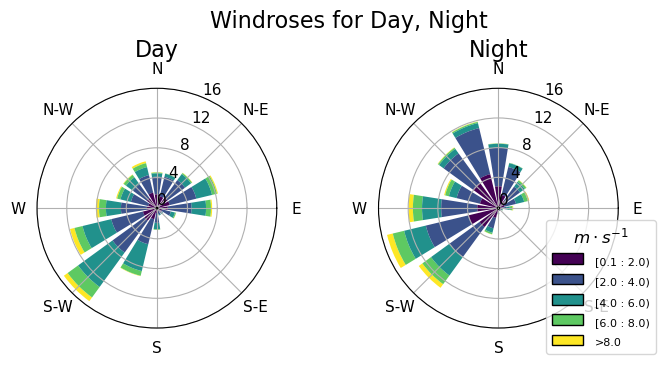

In [325]:
# Plot windrose for day and night
datprep.plot_windrose_grid(data=flux_data_all, sepcol='Night', direction='WD_2_1_1', speed='WS_1_1_1', titles=['Day', 'Night'])
# Save this plot
plt.savefig("/home/jovyan//ICOS-M2-internship-alise/data_plots/windrose_daynight.png", dpi=300, bbox_inches='tight')

These windroses show that the wind blows mainly from the pass towards the station (SW of the flux tower), which is explained by the dominant wind regime of the Northern Hemisphere, reinforced by the channeling effect of the topography. Furthermore, the diurnal cycle is characterized by anabatic and katabatic winds. At night, the wind flows along the slope of the ridge, coming from N/NW. During the day, because of topography and solar radiation, the wind rises from the valley, to the East.

## 3) 2) Phenologic phases (based on NDVI)

### Import and prepare the data

In [326]:
# Import NDVI values from 2019 to 2023
NDVI_all = datprep.read_csv_file('/mnt/data-summer-shared/ICOS_Data_AliseROBERT/*_Lautaret_halfhour.csv', na_values=[-9999.0])

In [327]:
# Change the name of the first column of NDVI_2023 into TIMESTAMP (standardization)
NDVI_all[4].columns.values[0] = "TIMESTAMP"
NDVI_all[5].columns.values[0] = "TIMESTAMP"

In [328]:
# Select only interesting columns : time and NDVI values
useful_columns = ['TIMESTAMP','NDVI_skye_ref']
NDVI_all = [NDVI[useful_columns] for NDVI in NDVI_all]

In [329]:
# Concatenate all the dataframes
NDVI_data_all = pd.concat(NDVI_all, ignore_index=True)
df = NDVI_data_all

### Smooth the NDVI

In [330]:
# Change the TIMESTAMP format into DatetimeIndex
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
df = df.set_index('TIMESTAMP')

In [331]:
# Smooth the data with rooling median (20 values, centered) then rolling mean (30 values, centered) on daily median
df['NDVI_smoothed'] = df['NDVI_skye_ref'].resample('d').median().rolling(20, center = True).median().rolling(30,center=True).mean()

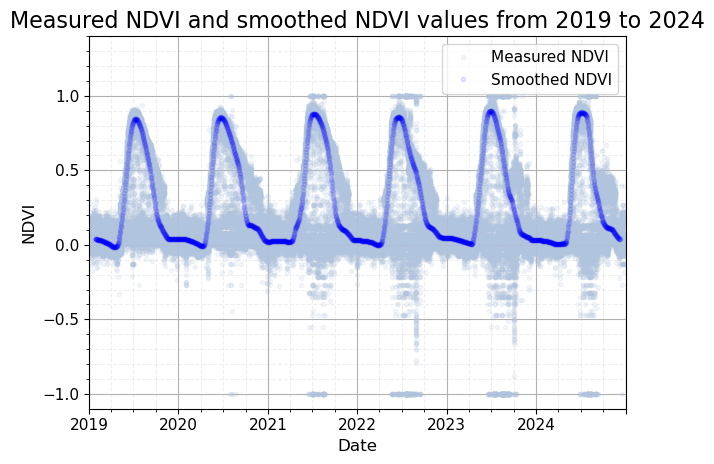

In [332]:
# Plot the measured NDVI values (light blue) and the smoothed NDVI (dark blue)
fig, ax = plt.subplots()

df['NDVI_skye_ref'].plot(ax=ax, style='.', alpha=0.15, color='lightsteelblue', label='Measured NDVI')
df['NDVI_smoothed'].plot(ax=ax, style='.', alpha=0.1, color='blue', label='Smoothed NDVI')

# Add a grid
grid_y_ticks = np.arange(-1.0, 1.5, 0.1)
ax.grid(which = 'both')
ax.set_yticks(grid_y_ticks , minor = True)
ax.grid(which = 'minor', alpha = 0.2, linestyle = '--')

ax.set_ylabel('NDVI')
ax.set_xlabel('Date')
ax.set_title("Measured NDVI and smoothed NDVI values from 2019 to 2024")
ax.legend()

plt.tight_layout()
plt.show()

This plot, representing the measured and smoothed NDVI as a function of time, shows that the NDVI follows a seasonal pattern linked to the vegetation stages and the snow cover. So the next step will be to isolate these phases.

### Detect the different phases of NDVI

In [333]:
# Remove the ligns where NDVI_smoothed is NaN
df = df.dropna(subset=['NDVI_smoothed'])

In [334]:
# Detect the different phases thanks to the derivative
df = datprep.detect_phase(df)

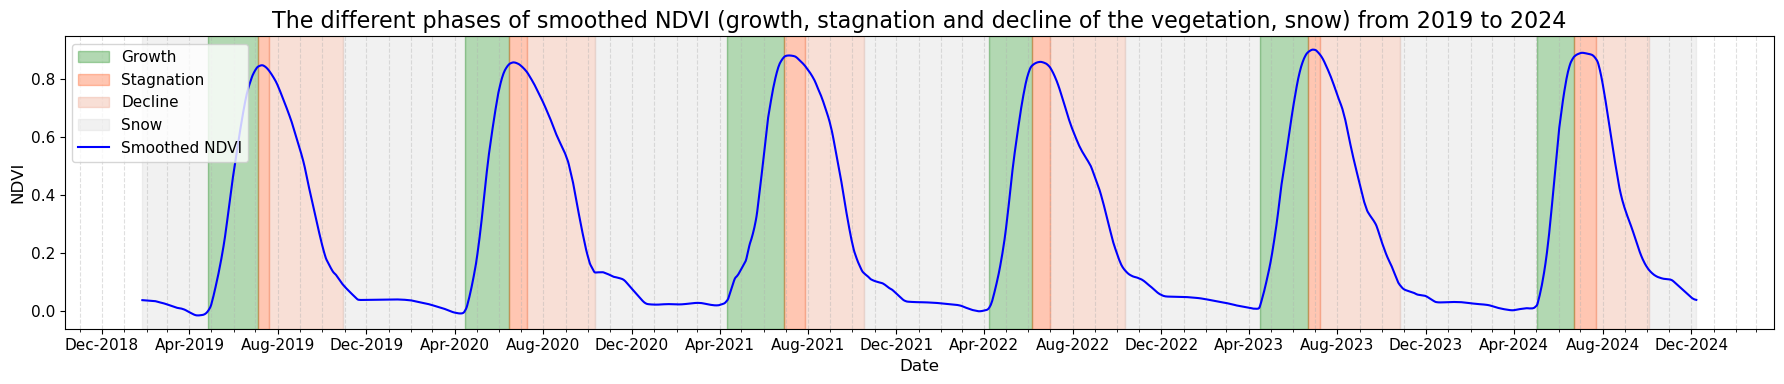

In [335]:
# Plot the smoothed NDVI with the different phases 
colors = {'Growth': 'green', 'Stagnation': 'orangered', 'Decline': 'darksalmon', 'Snow': 'lightgray'}
fig, ax = plt.subplots(figsize=(18, 4))
ax.plot(df.index, df['NDVI_smoothed'], label='Smoothed NDVI', color='blue')

# Add colored bands
current = df['phase_label'].iloc[0]
start = df.index[0]

for i in range(1, len(df)):
    phase = df['phase_label'].iloc[i]
    if phase != current:
        ax.axvspan(start, df.index[i], color=colors.get(current, 'white'), alpha=0.3)
        start = df.index[i]
        current = phase

ax.axvspan(start, df.index[-1], color=colors.get(current, 'white'), alpha=0.3)

# Set the x axis scaling
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
ax.grid(True, axis='x', which='both', linestyle='--', alpha=0.4)

ax.set_title("The different phases of smoothed NDVI (growth, stagnation and decline of the vegetation, snow) from 2019 to 2024")
plt.ylabel('NDVI')
plt.xlabel('Date')

# Add color legend
patches = [mpatches.Patch(color=color, alpha=0.3, label=phase) for phase, color in colors.items()]
ax.legend(handles=patches + [plt.Line2D([], [], color='blue', label='Smoothed NDVI')], loc='upper left')

plt.tight_layout()
plt.savefig('/home/jovyan//ICOS-M2-internship-alise/data_plots/NDVI_phases.png')
plt.show()

This plot represents the smoothed NDVI (blue line), with the different phases detected as a function of the derivative. It highlights the seasonal variability of NDVI and, by extension, that of vegetation and snow cover. The different durations and onsets of the phases for each year are more clearly distinguished. This information is relevant, because CO2 fluxes vary according to the phenological state of the grassland.

### Add the phases to the flux dataframe

In [336]:
# Add a "DATE" column in the flux dataframe
flux_data_all['DATE'] = pd.to_datetime(flux_data_all['TIMESTAMP_START']).dt.date

# Create a DataFrame with the name of the phase for each day
phases_NDVI = df[['phase_label']].copy()
phases_NDVI = phases_NDVI.reset_index()
phases_NDVI['DATE'] = phases_NDVI['TIMESTAMP'].dt.date
phases_NDVI = phases_NDVI[['DATE', 'phase_label']]

# Merge by date
flux_NDVI = pd.merge(
    flux_data_all,
    phases_NDVI,
    on='DATE',
    how='left'
)

# Remove 'DATE'
flux_NDVI.drop(columns='DATE', inplace=True)
 
print(flux_NDVI)

          TIMESTAMP_START  WS_1_1_1  MO_LENGTH_1_1_1  V_SIGMA_1_1_1  \
0     2019-06-01 00:00:00  0.993511         11.24490       0.513305   
1     2019-06-01 00:30:00  0.828337        -12.36150       0.401650   
2     2019-06-01 01:00:00  0.737088        -91.58720       0.510083   
3     2019-06-01 01:30:00  1.490440         18.69130       0.643529   
4     2019-06-01 02:00:00  1.242340         28.58040       0.586084   
...                   ...       ...              ...            ...   
82977 2024-12-12 07:30:00  2.411070          5.65391       1.071670   
82978 2024-12-12 08:00:00  2.338090         11.39640       0.670925   
82979 2024-12-12 08:30:00  2.047130         31.55550       0.747267   
82980 2024-12-12 09:00:00  1.951880          3.16540       0.541416   
82981 2024-12-12 09:30:00  2.581270          8.14935       0.751708   

       USTAR_1_1_1  D_SNOW_1_1_1  WD_2_1_1  h_capteur     zm  H_RANDOM  Night  \
0         0.146562           NaN    252.10       5.01  5.010    10

### Save the flux dataframe

In [337]:
flux_NDVI.to_csv('/home/jovyan//ICOS-M2-internship-alise/data_plots/flux_NDVI.csv', index=False)

# Conclusion

**In this section, different periods are isolated. This processing is essential, because wind regime evolves from night to day and can have an impact on the flux origin. As for the vegetation phases, their categorization will facilitate the interpretation of CO2 sources. Vegetation is expected to sequester less during stagnaton and decline than during plant growth. The output of this notebook is a csv file with all the required variables for flux footprint calculation.**